## COMP 3400: Data Preparation Techniques Project
## Analysis of popular movies from 1980 to 2019

**Group Members:**
  - Liudmila Strelnikova 201819885
  - David Chicas 201919354
  
## Part One: Changes From Iteration One
In this project submission you can find a PDF that addresses all the instrutor's comments about the changes we can make to Iteration 1 to improve it. Those changes have already been addressed in this Iteration.

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import string
import pandas as pd
import jinja2
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import QuantileTransformer

pd.options.mode.chained_assignment = None # chained assignments are not flagged

In [47]:
#Improved movies.csv exported from Iteration 1 as movies2.csv
movies2 = pd.read_csv("movies2.csv")

In [48]:
# Information about our dataset
movies2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7643 entries, 0 to 7642
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      7643 non-null   object 
 1   rating    7575 non-null   object 
 2   genre     7643 non-null   object 
 3   year      7643 non-null   int64  
 4   score     7643 non-null   float64
 5   director  7643 non-null   object 
 6   country   7643 non-null   object 
 7   budget    5484 non-null   float64
 8   gross     7466 non-null   float64
 9   company   7632 non-null   object 
 10  runtime   7643 non-null   float64
 11  date      7643 non-null   object 
dtypes: float64(4), int64(1), object(7)
memory usage: 716.7+ KB


In [49]:
# Missing values in our dataset
movies2.isnull().sum().sort_values(ascending=False)

budget      2159
gross        177
rating        68
company       11
name           0
genre          0
year           0
score          0
director       0
country        0
runtime        0
date           0
dtype: int64

## Part Two: Data Scaling Pre-Assessment

### Scaling numeric data (score, runtime, gross)

In this part of our project we will explore different scaling techniques to decide on the best option for our data. The three attributes we are going to start with are are **score, runtime and gross** as they are already provided in a continuous numberic format and do not need to be encoded. 

In [50]:
#ndf is movies2 that only contains score, runtime and gross – continuous numeric attributes
ndf = movies2[['score', 'runtime', 'gross']].dropna()
ndf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7466 entries, 0 to 7642
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   score    7466 non-null   float64
 1   runtime  7466 non-null   float64
 2   gross    7466 non-null   float64
dtypes: float64(3)
memory usage: 233.3 KB


To compare different scaling techniques, we are going to plot score, runtime and gross histograms with their density functions. 

In [51]:
#The function plots graphs in a grid whose dimentions are (number of attributes) x 7.
#The first column in a grid contains histograms and density functions of unscaled attributes. 
#All consequent columns contain histograms and density functions of the attributes scaled with 
#various scaling techniques, the names of which are provided in the scaler_names variable as an array.

# @df is the dataframe with numeric attributes 
# @columns is an array with the names of attributes; the variable is misnamed as it technically represents
# rows
# @fig_title is the overall title of all the plots
# @scalers is an array with callable scaler functions
# @scaler_names is an array with scaler names as strings
#
def plot_histograms_density_for_scalers(df, columns, fig_title, scalers, scaler_names):
    fig, axs = plt.subplots(len(columns),len(scalers)+1,figsize=(16,18),constrained_layout=True)
    fig.suptitle(fig_title, fontsize=16)
    axs = axs.flatten()
    i = 0 
    for c in columns:
        df[c].hist(ax=axs[i], density=True) # normalizes the density
        df[c].plot.density(ax=axs[i], title=c)
        i+=1
        for j in range(len(scalers)):
            df_transformed = scalers[j].fit_transform(df)
            df_transformed = pd.DataFrame(df_transformed, index=df.index, columns=df.columns)
            df_transformed[c].hist(ax=axs[i], density=True, stacked=True) # normalizes the density
            df_transformed[c].plot.density(ax=axs[i], title=scaler_names[j])
            i+=1

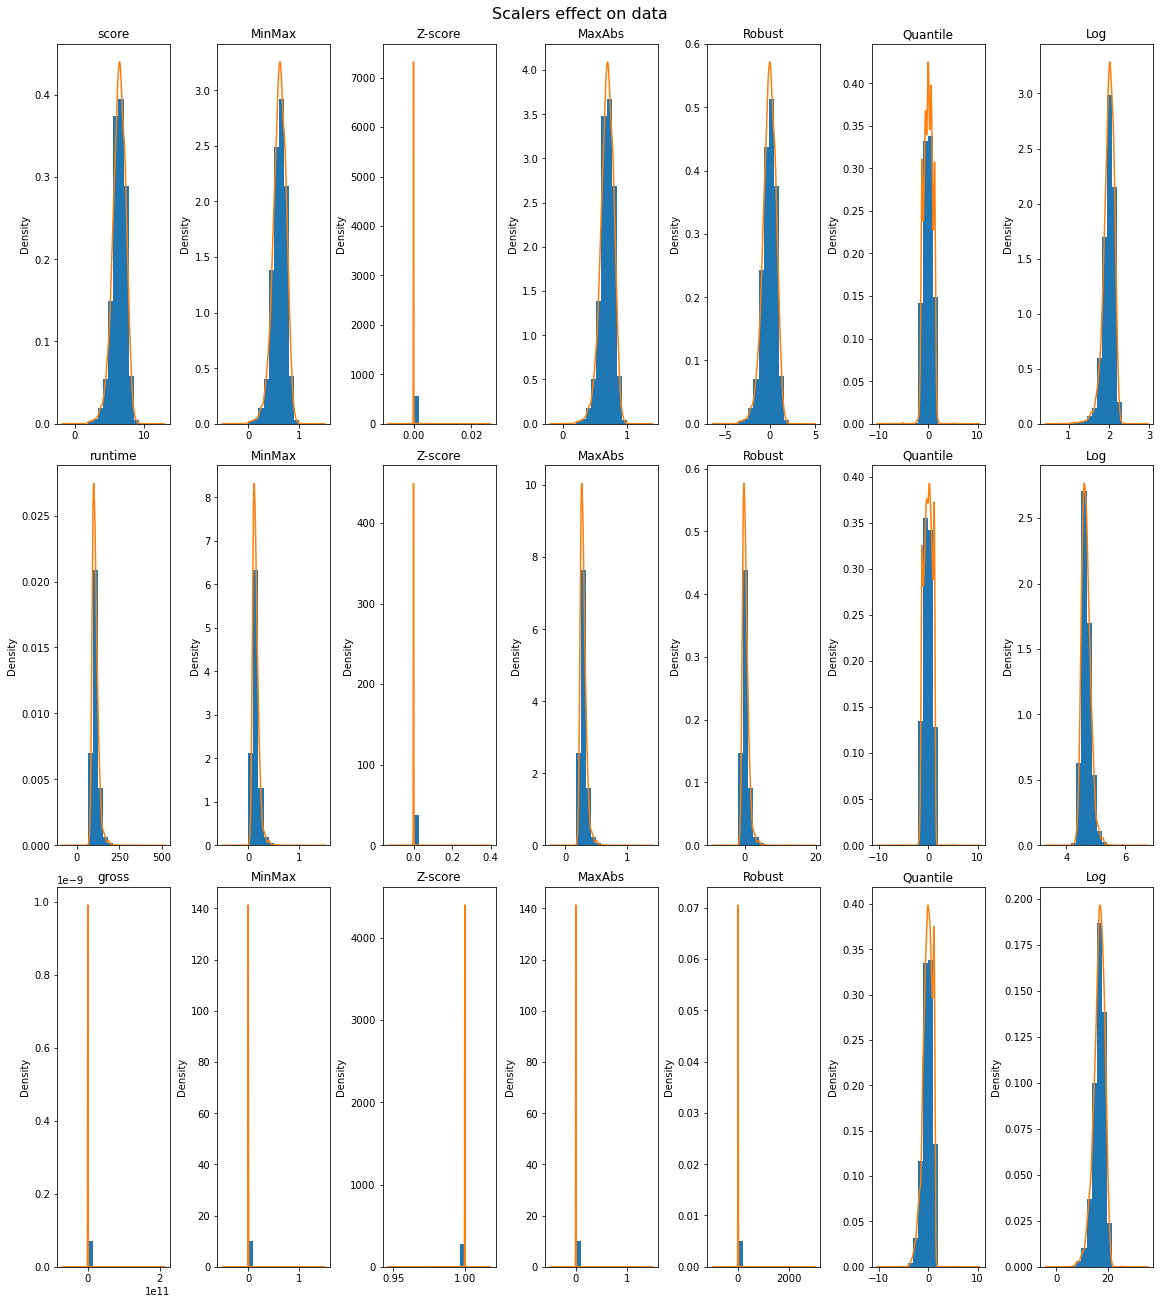

In [52]:
val_cols_names = ['score','runtime','gross']
scaler_names = ['MinMax', 'Z-score', 'MaxAbs', 'Robust', 'Quantile', 'Log']
arr_scalers = [MinMaxScaler(), Normalizer(), MaxAbsScaler(), RobustScaler(), QuantileTransformer(n_quantiles=10, random_state=0, output_distribution='normal'),FunctionTransformer(np.log1p)]
plot_histograms_density_for_scalers(ndf, val_cols_names, 'Scalers effect on data', arr_scalers, scaler_names)

All of the attributes explored have normal distributions that are only slightly skewed, therefore standardization techniques such as **Z-score** and **Log** would work best for them. **Log** is especially useful as it typically works well for data with large variances such as **gross**. 

Normalization techniques such as **MinMax** and **MaxAbs** are not robust against outliers, and are only typically used when the distribution of data is unknown. **Robust** normalization technique however could also work well with our data as it is robust agains outliers. 

To choose the most appropriate scaling technique between **Log**, **Z-score**, and **Robust**, some other attributes should be considered such as **country**, **rating** and **genre** which are encoded and scaled in the next section. 

### Encoding and scaling qualitative data (rating, genre, country)

Unsupervised learning models only use continuous attributes, therefore attributes **rating, genre, and  country** should be encoded. 
The attributes do not possess much hierarchy, and can be encoded with a simple **label encoder**.

In [53]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder() 
df_le = movies2.copy()

df_le['rating_en'] = le.fit_transform(df_le['rating'])
df_le['genre_en'] = le.fit_transform(df_le['genre'])
df_le['country_en'] = le.fit_transform(df_le['country'])

to_drop = ['rating', 'genre', 'country']
df_le = df_le.drop(to_drop,axis=1)

#A roundabout way to encode attributes and give them original names
df_le = df_le.rename(columns = {"rating_en":"rating", "genre_en":"genre", "country_en":"country"})
#The movies2 df now has encoded values
movies2 = df_le
movies2.head(10)

,name,year,score,director,budget,gross,company,runtime,date,rating,genre,country
0,The Shining,1980,8.4,Stanley Kubrick,19000000.0,46998772.0,Warner Bros.,146.0,1980-06-13,5,6,54
1,The Blue Lagoon,1980,5.8,Randal Kleiser,4500000.0,58853106.0,Columbia Pictures,104.0,1980-07-02,5,1,55
2,Star Wars: Episode V - The Empire Strikes Back,1980,8.7,Irvin Kershner,18000000.0,538375067.0,Lucasfilm,124.0,1980-06-20,3,0,55
3,Airplane!,1980,7.7,Jim Abrahams,3500000.0,83453539.0,Paramount Pictures,88.0,1980-07-02,3,4,55
4,Caddyshack,1980,7.3,Harold Ramis,6000000.0,39846344.0,Orion Pictures,98.0,1980-07-25,5,4,55
5,Friday the 13th,1980,6.4,Sean S. Cunningham,550000.0,39754601.0,Paramount Pictures,95.0,1980-05-09,5,10,55
6,The Blues Brothers,1980,7.9,John Landis,27000000.0,115229890.0,Universal Pictures,133.0,1980-06-20,5,0,55
7,Raging Bull,1980,8.2,Martin Scorsese,18000000.0,23402427.0,Chartoff-Winkler Productions,129.0,1980-12-19,5,3,55
8,Superman II,1980,6.8,Richard Lester,54000000.0,108185706.0,Dovemead Films,127.0,1981-06-19,3,0,55
9,The Long Riders,1980,7.0,Walter Hill,10000000.0,15795189.0,United Artists,100.0,1980-05-16,5,3,55


Now that the attributes **rating, genre, and  country** are encoded, the same scaling investigation can be applied as to **gross, budget, and score** in the previous section. 

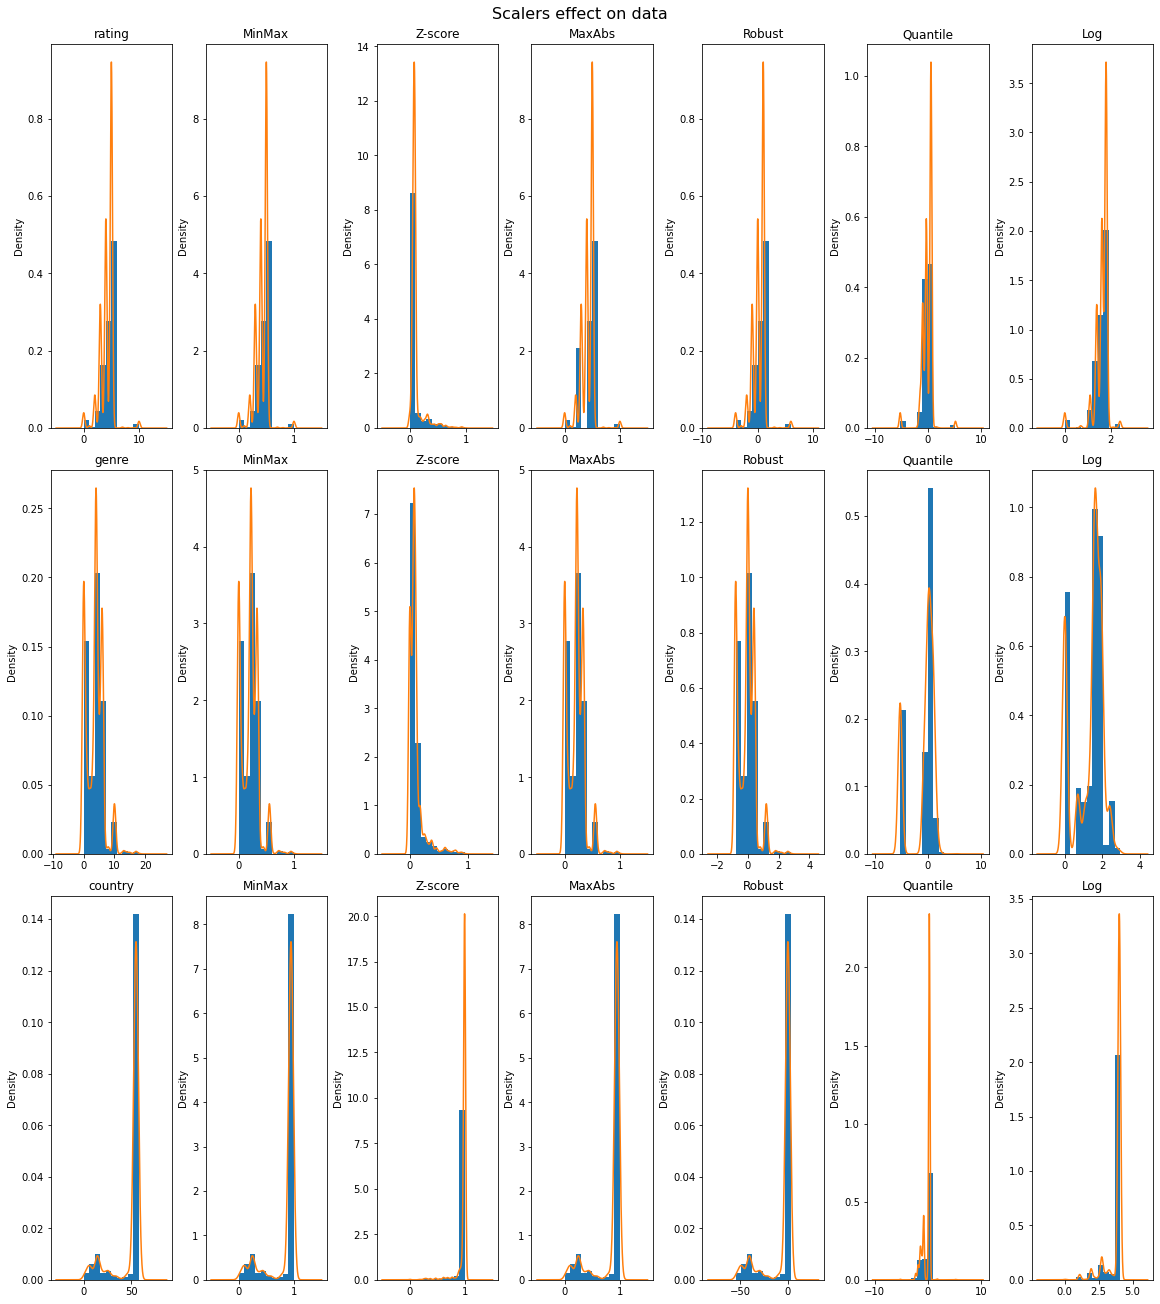

In [54]:
ndf2 = movies2[['rating','genre','country']].dropna()
val_cols_names = ['rating','genre','country']
scaler_names = ['MinMax', 'Z-score', 'MaxAbs', 'Robust', 'Quantile', 'Log']
arr_scalers = [MinMaxScaler(), Normalizer(), MaxAbsScaler(), RobustScaler(), QuantileTransformer(n_quantiles=10, random_state=0, output_distribution='normal'),FunctionTransformer(np.log1p)]
plot_histograms_density_for_scalers(ndf2, val_cols_names, 'Scalers effect on data', arr_scalers, scaler_names)

From the graphs above, we can see that all attributes are significantly skewed (especially country since most popular movies come from the US nowadays). Therefore, the standardization teqniques chosen before (**Z-score and Log**) would NOT give good scaling results. 

Among the normalization techniques, **Robust** would be the best chose as it is the most robust to outliers.

## Part Three: Handling Missing Data & Outliers

The supervised learning model that we are going to use in the future, only accepts numeric attributes, so columns **name, director, company and date** should be dropped**. 

In [55]:
to_drop = ['name', 'director', 'company', 'date']
m2 = movies2.drop(to_drop, axis=1)
m2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7643 entries, 0 to 7642
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     7643 non-null   int64  
 1   score    7643 non-null   float64
 2   budget   5484 non-null   float64
 3   gross    7466 non-null   float64
 4   runtime  7643 non-null   float64
 5   rating   7643 non-null   int64  
 6   genre    7643 non-null   int64  
 7   country  7643 non-null   int64  
dtypes: float64(4), int64(4)
memory usage: 477.8 KB


### Outliers

Before moving to the supervised learning, we should decide on the baseline strategy when dealing with missing values and outliers. From the distributions below, we can see that attributes **budget, gross, runtime, rating, and genre** have a lot of outliers above the maximum value (Q3 + 1.5 IQR). Therefore, for these variables, we can use the IQR method as the base strategy. We will delete anything above the maximum value with the maximum value.

The same IQR method can be applied to the **score** attributes, except in this case, values below the minumum value (Q1 - 1.5 IQR) can be replaced with the minimum value. 

**Rating and genre** do not have many outliers, and can be left as they are. **Country** cannot lose it's outliers because it is a very skewed distribution (towards the English-speaking world), and by replacing the outliers, we might lose some underrepresented countries. 

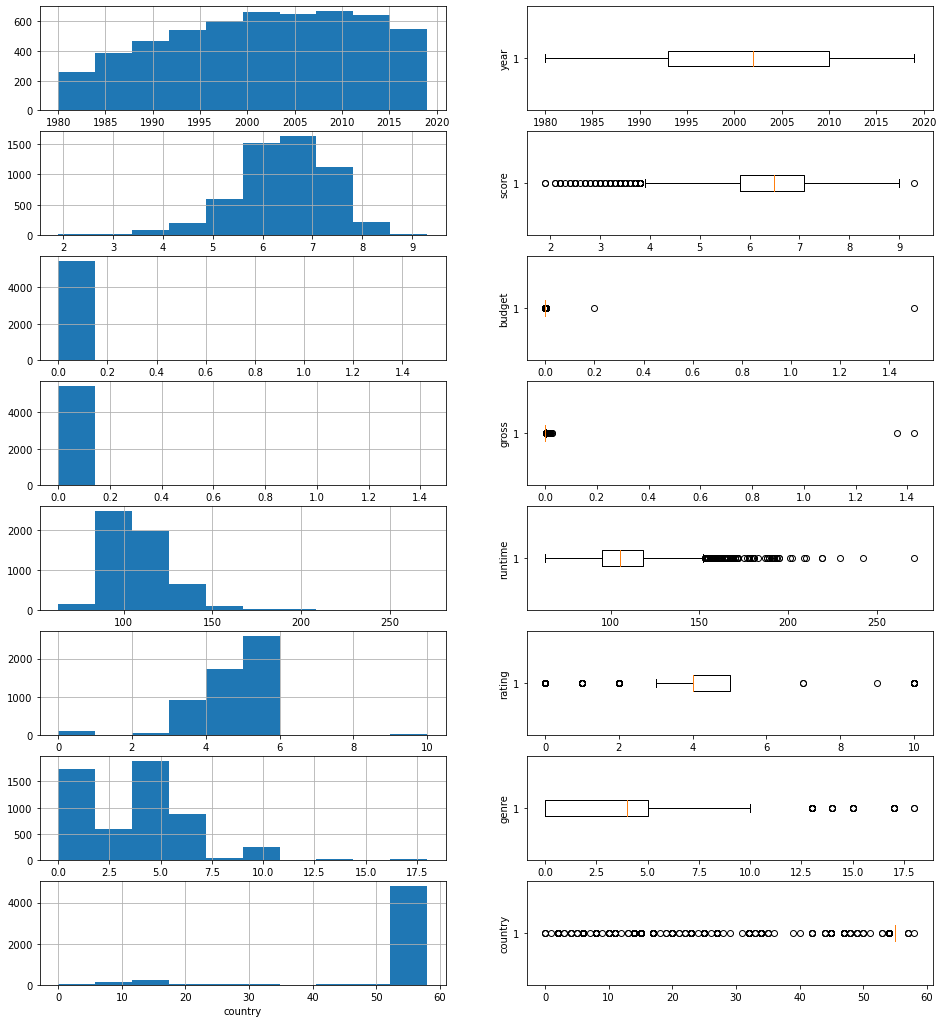

In [56]:
# The function plots a histogram and a box plot of attributes in df specified by the variable names
# @df is the dataframe used to plot data of
# @names is an array with the names of the attributes that need to be plotted
# figx, and figy is the dimentions of the plots 

def hist_box(df,names, figx, figy):
    fig, axs = plt.subplots(len(names),2,figsize=(figx,figy))
    axs = axs.flatten()
    i=0
    for n in names:
        df[n].hist(ax = axs[i])
        axs[i].set(xlabel=n)
        axs[i+1].boxplot(df[n],vert=False)
        axs[i+1].set(ylabel=n)
        i += 2  
names = ['year', 'score', 'budget','gross','runtime', 'rating', 'genre', 'country']
hist_box_data = m2[names].dropna()
hist_box(hist_box_data,names, 16, 18)

Cleaning outliers for **budget, gross, runtime, rating, and genre**.

In [57]:
# The function replaces outliers higher than the maximum value with the maximum value
# The replacement is done for the attributes specified in the variable columns
# @df is the dataframe for which the replacements are performed
# @columns is an array with the names of the attributes that need to be fixed

def replace_max_outliers_IQR(df, columns):
    for c in columns:
        q1=df[c].quantile(0.25)
        q3=df[c].quantile(0.75)
        iqr = q3-q1
        #low_lim = q1 - 1.5*iqr
        high_lim = q3 + 1.5*iqr
        df[c] = np.where(df[c] >= high_lim, high_lim, df[c])

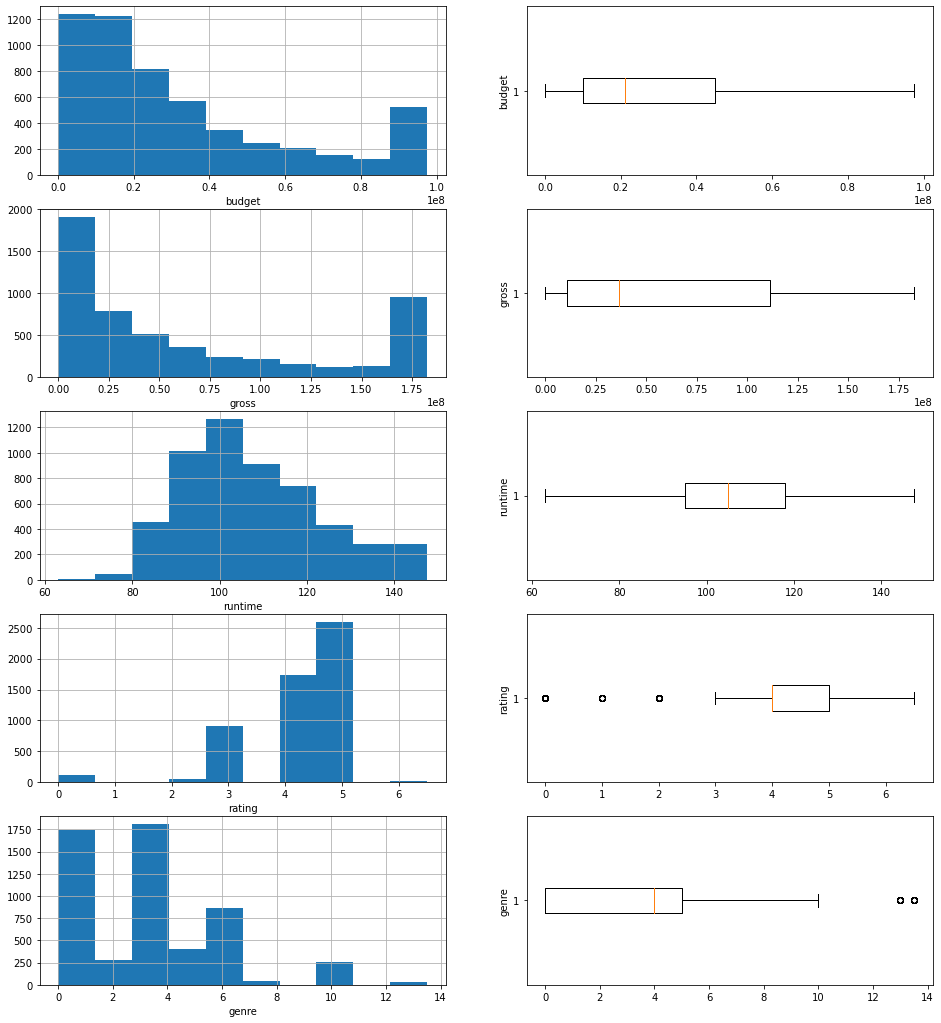

In [58]:
m2_copy = m2.copy()
IQR_names = ['budget', 'gross', 'runtime', 'rating', 'genre']
replace_max_outliers_IQR(m2_copy, IQR_names)
hist_box_data = m2_copy[IQR_names].dropna()
hist_box(hist_box_data,IQR_names, 16, 18)

Cleaning outliers for **score**.

In [59]:
# The function replaces outliers lower than the minimum value with the minimum value
# The replacement is done for the attributes specified in the variable columns
# @df is the dataframe for which the replacements are performed
# @columns is an array with the names of the attributes that need to be fixed
#
def replace_min_outliers_IQR(df, columns):
    for c in columns:
        q1=df[c].quantile(0.25)
        q3=df[c].quantile(0.75)
        iqr = q3-q1
        low_lim = q1 - 1.5*iqr
        df[c] = np.where(df[c] <= low_lim, low_lim, df[c])

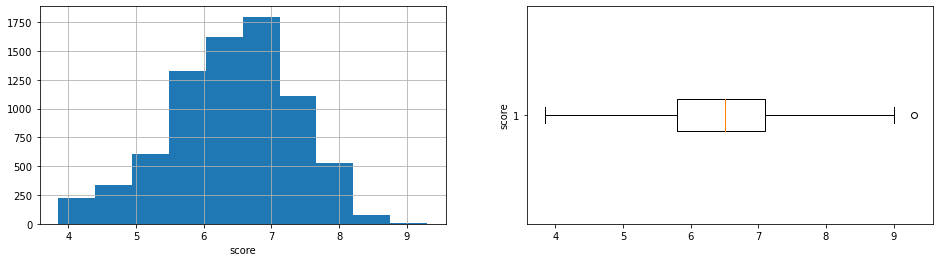

In [60]:
replace_min_outliers_IQR(m2_copy, ['score'])
hist_box_data = m2_copy[['score']].dropna()
hist_box(hist_box_data,['score'],16,4)

In [61]:
# Now that the outliers are cleaned up, the new cleaned dataframe is m2 again
m2 = m2_copy

In [62]:
m2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7643 entries, 0 to 7642
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     7643 non-null   int64  
 1   score    7643 non-null   float64
 2   budget   5484 non-null   float64
 3   gross    7466 non-null   float64
 4   runtime  7643 non-null   float64
 5   rating   7643 non-null   float64
 6   genre    7643 non-null   float64
 7   country  7643 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 477.8 KB


### Missing values 

The only attributes with missing values are gross and budget. Both of their distributions are very skewed, leaning towards bimodal. Therefore, baseline strategy of **replacing outliers with the mean** would not work as it only works for normally distributed data. 

The baseline strategy of **replacing the missing values with the median** might work well for the **gross** attribute as only about 2% of it's values are missing. The strategy might not work very well on the **budget** attribute however, as about 28% of data is missing.

In [63]:
#The dataframe with replaced values will be called m2_gross_replaced
m2_gross_replaced = m2.copy()

In [64]:
#The function transforms the dataframe by replacing its missing values with 
#either mean, meadian or NaN depending on which option is given in the agg_func variable.
#@df the dataframe that needs to be cleaned
#@agg_func is the string that is either 'median', 'mean', or nothing 
#depending on the baseline strategy chosen to replace the missing values.
#If nothing no variable is specified as agg_func the emplty cells are replaced with NaN.
#@columns is the array variable that specifies which columns contain missing values
#
def transform_aggregate(df, agg_func, columns):
    for c in columns:
        X = None
        if    agg_func == 'median':
            X = df[c].median()
        elif  agg_func == 'mean':
            X = df[c].mean()
        else: 
            X = df[c].mode()[0]
        df[c].fillna(X, inplace=True)
        
transform_aggregate(m2_gross_replaced, 'median', ['gross'])

To illustrate how the above function works, a few values from the gross attribute are plotted below. Only values with indices of 7350 to 7643 are plotted because there are too many data points to plot. 

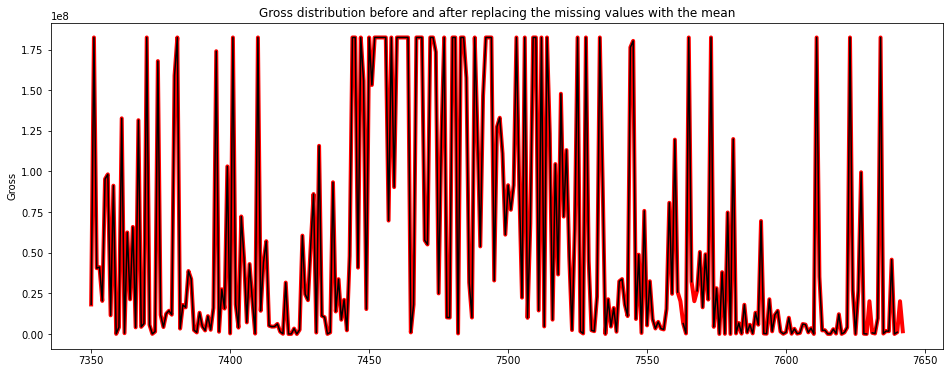

In [65]:
fig, axs = plt.subplots(figsize = (16,6))

#replaced variables
axs.plot(m2_gross_replaced['gross'].iloc[7350:], lw=4, color='red')
#original data with missing values
axs.plot(m2['gross'].iloc[7350:], color = 'black')
axs.set(ylabel = "Gross", title = "Gross distribution before and after replacing the missing values with the mean")

plt.show()

From the plot above, altough, we are only looking at a subset of data, we can still see that the baseline strategy works pretty well for replacing gross values.

We will now move on and try to predict the missing values for gross using the supervised learning model. 

## Choosing and training a supervised learning model

### Comparison of regression models

The fist attribute we can work with is **gross**; it has about 150 values missing. 

Before replacing missing values, we need to choose a model that would give best predictions. The two models we will compare are  **Linear Regression** and 2-K Nearest Neighbour Regression or **KNN**. Regression models are used because gross contains continuous data (as opposed to discrete for which classifiers would be more suitable). The metric used for cross-validation will be [R2 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score). 

In [66]:
# Saving rows to fix (the ones with missing data) in a separate dataframe
rows_to_fix_gross = m2[m2['gross'].isna()].copy()

In [67]:
rows_to_fix_gross.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177 entries, 27 to 7641
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     177 non-null    int64  
 1   score    177 non-null    float64
 2   budget   54 non-null     float64
 3   gross    0 non-null      float64
 4   runtime  177 non-null    float64
 5   rating   177 non-null    float64
 6   genre    177 non-null    float64
 7   country  177 non-null    int64  
dtypes: float64(6), int64(2)
memory usage: 12.4 KB


In [68]:
# Saving the rows with no missing values into a separate dataframe
# No missing values should be present when training a model
m2_clean = m2.dropna()

In [69]:
m2_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5430 entries, 0 to 7616
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     5430 non-null   int64  
 1   score    5430 non-null   float64
 2   budget   5430 non-null   float64
 3   gross    5430 non-null   float64
 4   runtime  5430 non-null   float64
 5   rating   5430 non-null   float64
 6   genre    5430 non-null   float64
 7   country  5430 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 381.8 KB


In [70]:
# Installing the necessary packages for unsupervised learning
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

The scalers that we chose previously were Quantile and Log. We will also try to use other scalers to see how they affect the predicitons. 

In [71]:
scaler_names = ['MinMax', 'MaxAbs', 'Z-score', 'Robust', 'Log', 'Quantile']
arr_scalers = [MinMaxScaler(), MaxAbsScaler(), Normalizer(), RobustScaler(), FunctionTransformer(np.log1p), QuantileTransformer(n_quantiles=10, random_state=0, output_distribution='normal')]
results = {}

In [72]:
# The function takes training dataframe (without missing values) and 
# isolates the values of y (gross column in this case), and X (all other columns).
# It then applies scaling techniques to X as specified by the arr_scalers variable. 
# With X, and y value, repeated k-fold cross-validation is then performed
# In the k-fold validation,n_splits = 10, and n_repeats = 5 to produce 50 estimates for future predictions
# The output is then stored in a results dictionary, where the keys are scaler names, and the values
# are cross-validation scores.
# R2 score is used as the metric to measure the accuracy of results. 

# @model is either linear regression model or KNN regression model
# @arr_scalers is an array with scaling techniques 
# @scaler_names is an array with the string names of the scaling techniques 
# @df is the training dataframe
# @results is a dictionary where results of the function are stored

def training_tests(df, model, arr_scalers, scaler_names, results):
    for i in range (len(arr_scalers)):
        # X is all variables except gross
        X = m2_clean.drop(['gross'], axis=1).to_numpy()

        # Scaling X    
        X_t = arr_scalers[i].fit_transform(X)

        # y is gross that we want to forecast
        y = m2_clean['gross'].to_numpy()
        cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
        scores = cross_val_score(model, X_t, y, scoring='r2', cv=cv, n_jobs=-1)
        results[scaler_names[i]] = scores
        
    # The model with the raw data just to put the models side-by-side
    X = m2_clean.drop(['gross'], axis=1).to_numpy()
    X_t = arr_scalers[i].fit_transform(X)
    y = m2_clean['gross'].to_numpy()
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    scores = cross_val_score(model, X_t, y, scoring='r2', cv=cv, n_jobs=-1)
    results['Raw data'] = scores

It is worth mentioning that for KNN neighbours parameter was chosen as roughly the square root of the number of samples as advised in [this article](https://towardsdatascience.com/a-simple-introduction-to-k-nearest-neighbors-algorithm-b3519ed98e). The square root of 5430 is around 73.

To visually compare R2 scores from different models, they are stored as dataframes **lin** and **knn**.

In [73]:
# Linear Model
model = LinearRegression()
training_tests(m2_clean, model, arr_scalers, scaler_names, results)
# dataframe for linear model score results
lin = pd.DataFrame(results)

# KNN Model
model = KNeighborsRegressor(n_neighbors=73) 
training_tests(m2_clean, model, arr_scalers, scaler_names, results)
# dataframe for KNN model score results
knn = pd.DataFrame(results)

The results are plotted as boxplots for comparison.

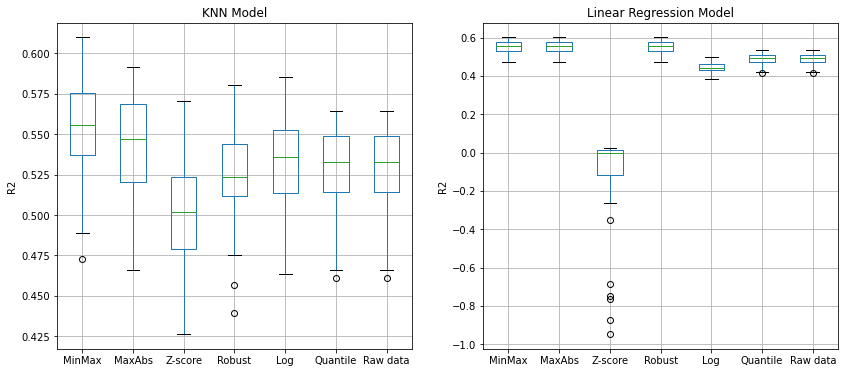

In [74]:
fig, axs = plt.subplots(1,2,figsize=(14,6))

knn.boxplot(ax=axs[0])
# knn.boxplot(ax = axs[0])
axs[0].set(title = "KNN Model", ylabel = "R2")

# lin.boxplot(ax = axs[1])
lin.boxplot(ax = axs[1])
axs[1].set(title = "Linear Regression Model", ylabel = "R2")

plt.show()

Clearly, Z-score scaling does not work very well for the predictions as it's R-value is very low with the Linear Regression model. To have a better comparison of the two models, below are the box plots without Z-score. 

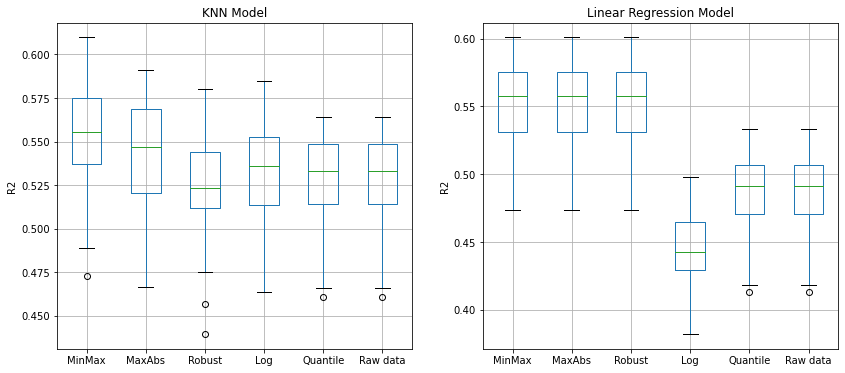

In [75]:
scaler_names = ['MinMax', 'MaxAbs', 'Robust', 'Log', 'Quantile']
arr_scalers = [MinMaxScaler(), MaxAbsScaler(), RobustScaler(), FunctionTransformer(np.log1p), QuantileTransformer(n_quantiles=10, random_state=0, output_distribution='normal')]
results = {}

# Linear Model
model = LinearRegression()
training_tests(m2_clean, model, arr_scalers, scaler_names, results)
# dataframe for linear model score results
lin = pd.DataFrame(results)

# KNN Model
model = KNeighborsRegressor(n_neighbors=73) 
training_tests(m2_clean, model, arr_scalers, scaler_names, results)
# dataframe for KNN model score results
knn = pd.DataFrame(results)

fig, axs = plt.subplots(1,2,figsize=(14,6))

knn.boxplot(ax=axs[0])
# knn.boxplot(ax = axs[0])
axs[0].set(title = "KNN Model", ylabel = "R2")

# lin.boxplot(ax = axs[1])
lin.boxplot(ax = axs[1])
axs[1].set(title = "Linear Regression Model", ylabel = "R2")

plt.show()

From the graphs above, it seems that **KNN model** works better _in general_, as it gives higher R2-scores and about the same variances. Overall, the best model + scaling techniques seem to be **KNN + MinMax, KNN + MaxAbs**, and **Linear Regression Model + either MinMax, MaxAbs, or Robust**. 

Below are the numeric statistics for all of the models and scaling techniques that will help us decide the best combination between the abovementioned.  

In [76]:
knn.describe()

,MinMax,MaxAbs,Robust,Log,Quantile,Raw data
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.553935,0.542470,0.525221,0.533468,0.528277,0.528277
std,0.031081,0.030925,0.029851,0.028699,0.027006,0.027006
min,0.472995,0.466215,0.439461,0.463571,0.460972,0.460972
25%,0.537195,0.520375,0.511557,0.513555,0.514372,0.514372
50%,0.555431,0.546900,0.523217,0.535903,0.532878,0.532878
75%,0.575252,0.568587,0.544050,0.552481,0.548844,0.548844
max,0.609761,0.591362,0.580082,0.585024,0.564030,0.564030


In [77]:
lin.describe()

,MinMax,MaxAbs,Robust,Log,Quantile,Raw data
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.551872,0.551872,0.551872,0.443582,0.486445,0.486445
std,0.030037,0.030037,0.030037,0.028450,0.029907,0.029907
min,0.473560,0.473560,0.473560,0.382200,0.412828,0.412828
25%,0.531392,0.531392,0.531392,0.429466,0.470321,0.470321
50%,0.557597,0.557597,0.557597,0.442945,0.491104,0.491104
75%,0.575496,0.575496,0.575496,0.464645,0.506879,0.506879
max,0.600778,0.600778,0.600778,0.497926,0.533230,0.533230


From the statistics above, it looks like for KNN,  **MinMax** scaling technique has the best R-score of about **55.3%**, which is only slightly higer than R-score of 54% for KNN + MaxAbs model. 

For Linear Regression Model, **MinMax, MaxAbs, and Robust** have similar R-scores of **55.2**%. 

When we look at the data spread, 50% of the data in KNN + MinMax scaling technique model varies between **53.8 and 57.5** percent. For the Linear Regression Model + (MinMax, MaxAbs, and Robust) scaling technique, 50% of data varies between **53.1 and 57.5** percent. 

Even though the statistics seem to be pretty similar, we decided that the best model for gross attribute predictions is **KNN Regression model with MinMax** scaling. The model has the highest R-score values, and low variance. 

### Predictions with the chosen model

In [78]:
#rows with missing gross values are rows we need to predict
rows_to_fix_gross = m2[m2['gross'].isna()].copy()
#we have to make sure those rows do not have missing values, so budget rows
#with missing values are deleted
rows_to_fix_gross = rows_to_fix_gross[rows_to_fix_gross['budget'].notna()]

rows_to_fix_gross.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54 entries, 27 to 7567
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     54 non-null     int64  
 1   score    54 non-null     float64
 2   budget   54 non-null     float64
 3   gross    0 non-null      float64
 4   runtime  54 non-null     float64
 5   rating   54 non-null     float64
 6   genre    54 non-null     float64
 7   country  54 non-null     int64  
dtypes: float64(6), int64(2)
memory usage: 3.8 KB


In [79]:
# As a reminder,
# m2_clean is the clean dataset used for predictions
# rows_to_fix_gross is the dataset with missing values 

# Setting up Linear Regression model with Robust scaler
X = m2_clean.drop(['gross'], axis=1).to_numpy()
scaler = MinMaxScaler()
X_t = scaler.fit_transform(X)
y = m2_clean['gross'].to_numpy()

In [80]:
#Applying the model
model = KNeighborsRegressor(n_neighbors = 73)
model.fit(X_t, y)

# Predicting the missing values
X_to_pred = rows_to_fix_gross.drop(['gross'], axis=1).to_numpy()
X_t_to_pred = scaler.transform(X_to_pred)
y_pred = model.predict(X_t_to_pred)

rows_to_fix_gross['gross'] = y_pred
m2_predicted = pd.concat([m2_clean, rows_to_fix_gross])

Now that the prediciton is done, we can plot two plots with data distribution before and after the prediciton. Only the slice of the first 1000 values is chosen for the plot, as it would be difficult to plot all fo them on one graph. 

In [81]:
#The dataframe to see how well the predictions worked on a plot
m2_compare = m2[m2['budget'].notna()]

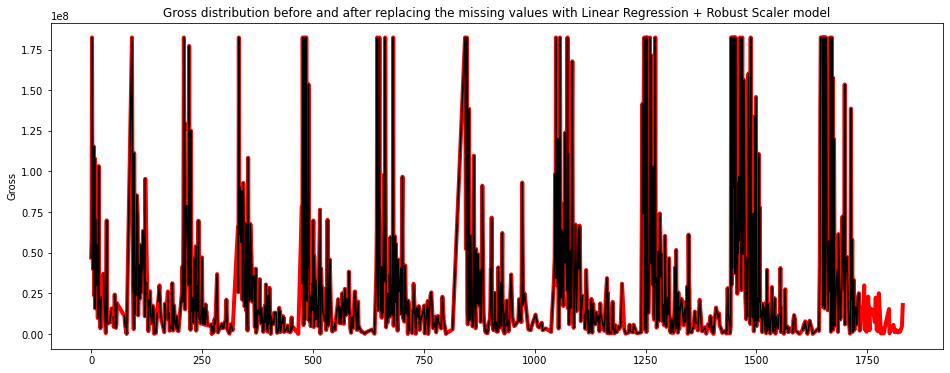

In [82]:
fig, axs = plt.subplots(figsize = (16,6))

#replaced variables
axs.plot(m2_predicted['gross'].iloc[:1000], lw=4, color='red')
#original data with missing values
axs.plot(m2_compare['gross'].iloc[:1000], color = 'black')
axs.set(ylabel = "Gross", title = "Gross distribution before and after replacing the missing values with Linear Regression + Robust Scaler model")

plt.show()

From the graph above, it appears that the unsupervised learning model does a good job predicting missing values. The numeric value evaluating the model's performance will be calculated in the next section.

### Evaluation Metric

To test how well this metric behaves with our model, we decided to run [r2_score metric test](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) which compares and array of known values to an array of predicted values and gives us percent accuracy between the two arrays. Below is the formula that is used for the r2-score metric test.

$$R^2 = 1 - \frac{SS_{regression}}{ SS_{total}}\,$$


To run this test, we deleted first thirty "gross" values from the clean m2_clean dataset and predicted them with our model. We then compared the known first thirty values to the predicted ones. Overall, the accuracy between the two compared arrays was determined to be around 27%. This means that about 73% of our values were not predicted accurately. To fix this, more advanced models than KNN could be tested, however this is beyond the content of this course.  

In [83]:
# gross_known_test contains first 30 rows of m2_clean
# it contants the known values for gross
gross_known_test = m2_clean.iloc[:30,:]

m2_deleted = m2_clean.copy()
# gross_deleted_test contains first 30 rows of m2_clean
# it's gross values are replaced with NaN, and will be predicted using our model later
m2_deleted['gross'].iloc[:30] = np.nan
gross_deleted_test = m2_deleted.iloc[:30]

# clean_test contains 5400 rows with no NaN values
# this df is used for training 
clean_test = m2_clean.iloc[30:,:]

# Training using clean_test
X = clean_test.drop(['gross'], axis=1).to_numpy()
scaler = MinMaxScaler()
X_t = scaler.fit_transform(X)
y = clean_test['gross'].to_numpy()

model = KNeighborsRegressor(n_neighbors = 73)
#model = LinearRegression()
model.fit(X_t, y)

# Predicting the missing values
X_to_pred = gross_deleted_test.drop(['gross'], axis=1).to_numpy()
X_t_to_pred = scaler.transform(X_to_pred)
y_pred = model.predict(X_t_to_pred)

gross_deleted_test['gross'] = y_pred

In [84]:
# Determining accuracy of results using r2_score metric
r2 = r2_score(gross_known_test['gross'], gross_deleted_test['gross'])
r2

0.267569165977783

In [87]:

hist_box(hist_box_data,['score'],16,4)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5484 entries, 0 to 7567
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     5484 non-null   int64  
 1   score    5484 non-null   float64
 2   budget   5484 non-null   float64
 3   gross    5484 non-null   float64
 4   runtime  5484 non-null   float64
 5   rating   5484 non-null   float64
 6   genre    5484 non-null   float64
 7   country  5484 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 385.6 KB


### Prediction tests with other scaling techniques

When the same evaluation is performed for the Linear Regressor + Robust scaler model (which we considered as one of the best models in the previous sections), we can see that the performance is much worse: only about 9%. 

In [85]:
# gross_known_test contains first 30 rows of m2_clean
# it contants the known values for gross
gross_known_test = m2_clean.iloc[:30,:]

m2_deleted = m2_clean.copy()
# gross_deleted_test contains first 30 rows of m2_clean
# it's gross values are replaced with NaN, and will be predicted using our model later
m2_deleted['gross'].iloc[:30] = np.nan
gross_deleted_test = m2_deleted.iloc[:30]

# clean_test contains 5400 rows with no NaN values
# this df is used for training 
clean_test = m2_clean.iloc[30:,:]

# Training using clean_test
X = clean_test.drop(['gross'], axis=1).to_numpy()
scaler = RobustScaler()
X_t = scaler.fit_transform(X)
y = clean_test['gross'].to_numpy()

model = LinearRegression()
model.fit(X_t, y)

# Predicting the missing values
X_to_pred = gross_deleted_test.drop(['gross'], axis=1).to_numpy()
X_t_to_pred = scaler.transform(X_to_pred)
y_pred = model.predict(X_t_to_pred)

gross_deleted_test['gross'] = y_pred

r2 = r2_score(gross_known_test['gross'], gross_deleted_test['gross'])
r2

0.08904916853573863

## Conclusion
In conclusion, we were able to predict the missing values for the attribute gross in our dataset.

We first encoded some qualitative data so that it could be used for meaningful quantitative analysis. Then, we explored various scaling techniques and predicted Robust Scaler to work best with out data. After that, we investigated combinations of Linear and KNN Regressors with different Scalers to identify the best model for supervised learning. After careful consideration, it appeared that KNN Regressor + MinMax Scaler would give us the best results. 

We then trained our data and successfully predicted the missing values for the gross attribute, with an accuracy of about 27%. We believe better accuracies could be achievd with more advanced Regression models which are beyond the scope of this course. 